# Black Jack stylised environment

## Deck Setup 
1. Card Suits : Spades, Hearts, Diamonds and Clubs
2. Face Cards : Kings, Queens and Jacks
3. Ace = Aces
4. Number cards : 2 to 10

# Card value setup

1. Face cards : 10
2. Ace : 11 if bust 1
3. Number : Numerical value equal to their number

# Reward Function

![Cost function](images/cost_function.png)

## Doubts
1. When calculating the score for the hand, when there is unusable ace, should be count that as 1 or 11?
2. How do we score and end the game when there is only one last card left in the deck and still the agent wants to stick?
4. How do I make reward after each state and action, question seems to give reward only after a hand is finished?
    1. *The reward in this game is sparse, as we only know how to label the last state in a hand with a reward. Think back to how the rewards are assigned in the chess example in the lectures - we give a non-zero reward at the end for a win/lose outcome and 0 otherwise for all other transitions.*


# TODO
1. Run variations iteration and find the nth iteration when the agent's q values shows minimal change to tell when the agent reached a optimal policy
2. Find other plots like training error, rewards throughout the iterations

# <font color='orange'>Inferences</font>

1. Tendency to stick increases at an early point of time (in terms of sum of the hand as state) with decrease in Gamma value

In [1]:
import numpy as np
import random

from utils.blackjack_env_builder import BlackJackStylised
from utils.scorer import Scorer, quadratic_scorer
from util.evaluator import evaluate_agent

from tqdm import tqdm
from matplotlib import pyplot as plt
from utils.general import plot_monte_carlo_q_values

In [2]:
# class MonteCarloES:
#     '''
#     Monte Carlo Exploring starts algorithm
#     '''
    
#     # TODO Print the number of states and actions along with the defined init_configurations
#     def __init__(self, states, actions, init_config:dict, verbose=False): # reward_function
        
#         self.states = states
#         self.actions = actions
#         self.init_config = init_config
#         # self.reward_function = reward_function
#         self.initialize_Q_returns()
        
#     def epsilon_greedy_policy(self, state):
        
#         if random.random() < self.init_config['epsilon']:
#             return random.choice(self.actions)
#         else:
#             return self._exploit(state)
        
#     def _exploit(self, state):
#         greedy_action = max(list(self.Q[state].keys()),
#                                 key=lambda x: self.Q[state][x]['value'])
#         return greedy_action
        
    
#     def initialize_Q_returns(self):
#         self.Q = {}
#         # self.returns = {}
#         for state in self.states:
#             action_dict = {}
#             for action in self.actions:
#                 # self.returns[(state, action)] = {'mean':0, 'count':0}
#                 action_dict[action] = {'value':self.init_config['init_state_action_val'], 
#                                        'count':0}
#             self.Q[state] = action_dict
            
            
#     # TODO Check this function
#     def _moving_average_returns(self, state, action, G):
        
#         curr_val = self.Q[state][action]['value']
#         count = self.Q[state][action]['count']
        
#         mov_avg = curr_val + ((G - curr_val)/count)
#         # mov_avg = (curr_val * count + G)/ count 
        
#         return mov_avg
            
        
#     def policy_evaluation(self, episode):
        
#         # Starting from reverse order for policy evaluation
#         # for episode in episodes:
#         state_repeat_check = []
#         G = 0
#         for state, action, reward in reversed(episode):

#             # TODO Check if returns are right
#             G = self.init_config['gamma']*G + reward

#             if (state, action) not in state_repeat_check:
#                 state_repeat_check.append((state, action))
#                 self.Q[state][action]['count'] += 1
#                 self.Q[state][action]['value'] = self._moving_average_returns(state, action, G)
            

In [62]:
class MonteCarloES:
    '''
    Monte Carlo Exploring starts algorithm
    '''
    
    # TODO Print the number of states and actions along with the defined init_configurations
    def __init__(self, init_config:dict, actions, verbose=False, epsilon_decay=False,
                 epsilon_decay_param={"min_epsilon":0.05, "max_epsilon":0, "decay_factor":0.0005}): 
        
        self.actions = actions
        self.init_config = init_config
        self.epsilon_decay_param = epsilon_decay_param
        self.oldQ = None
        if epsilon_decay:
            self.epsilon_decay_param['max_epsilon'] = self.init_config['epsilon']
        self.initialize_Q()
        
    def epsilon_greedy_policy(self, state):
        
        hand_sum, usable_ace = state
        # hand_sum, usable_ace, deck_feature = state
        if random.random() < self.init_config['epsilon']:
            return random.choice(self.actions)
        else:
            ## return np.argmax(self.Q[int(current_sum), usable_ace, deck_feature])
            return np.argmax(self.Q[int(hand_sum), usable_ace, :, 0])
        

        
    def initialize_Q(self):
        '''
        Zero initialized Q values
        '''
        self.Q = np.zeros((len(self.init_config['states']['state_dim_1']),
                           len(self.init_config['states']['state_dim_2']), len(self.actions), 2)) 
        
    
    def epsilon_decay(self, episode_num):
        
        min_epsilon = self.epsilon_decay_param['min_epsilon']
        max_epsilon = self.epsilon_decay_param['max_epsilon']
        decay_factor = self.epsilon_decay_param['decay_factor']
        
        self.init_config['epsilon'] = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_factor*episode_num) 
            
    def _moving_average_returns(self, hand_sum, usable_ace, action, G):
        
        curr_val = self.Q[hand_sum][usable_ace][action][0]
        count = self.Q[hand_sum][usable_ace][action][1]
        
        mov_avg = curr_val + ((G - curr_val)/count)
        # mov_avg = (curr_val * count + G)/ count + 1 
        
        return mov_avg
            
        
    def policy_evaluation(self, episode):
        
        # Starting from reverse order for policy evaluation
        # for episode in episodes:
        state_repeat_check = []
        G = 0
        for hand_sum, usable_ace, action, reward in reversed(episode):

            G = self.init_config['gamma']*G + reward

            if (hand_sum, usable_ace, action) not in state_repeat_check:
                state_repeat_check.append((int(hand_sum), usable_ace, action))
                # print(self.Q.shape)
                # print([int(hand_sum),usable_ace, action,1])
                # print()
                # self.oldQ = np.copy(self.Q)
                self.Q[int(hand_sum)][usable_ace][action][1] += 1
                self.Q[int(hand_sum)][usable_ace][action][0] = self._moving_average_returns(int(hand_sum), usable_ace, action, G)

                
def has_converged(previous_Q, current_Q, threshold=0.001):
    
    previous_Q_temp = previous_Q[:,:,:,0].ravel()
    current_Q_temp = current_Q[:,:,:,0].ravel()
    # print(f' is check : {previous_Q_temp is current_Q_temp}')
    
    delta = np.abs(current_Q_temp - previous_Q_temp)  #np.abs(
    # print(current_Q - previous_Q)
    return np.sum(delta) < threshold

## For infinite Decks

In [76]:
env = BlackJackStylised()

In [77]:
init_config= {'init_state_action_val': 0,
              'epsilon' : 0.25,
              'gamma' : 0.75,
              'states' : {'state_dim_1':list(range(2, 22)),
                          'state_dim_2': [0,1]}}
agent_v1 = MonteCarloES(init_config=init_config, actions=[0, 1], epsilon_decay=True)

In [78]:
cards, curr_sum, usable_ace, hand_complete = env.reset_init(hard=True)
sum_offset = 2
curr_sum -= sum_offset 
total_episodes = 1000000
episode_break_flag = True
converged = False
counter = 0
if not hand_complete:
    # episodes = []
    # for i in tqdm(list(range(total_episodes))):
    agent_v1.oldQ = np.copy(agent_v1.Q)
    while not converged:
        episode = []
        episode_break_flag = True
        while episode_break_flag:
            action = agent_v1.epsilon_greedy_policy((curr_sum, int(usable_ace)))
            cards, new_sum, usable_ace, hand_complete = env.step(action)
            
            
            if new_sum > 21 or hand_complete == True:
                episode_break_flag = False
                reward = quadratic_scorer(new_sum) #new_sum
                episode.append([curr_sum, int(usable_ace), action, reward])
                curr_sum = new_sum - sum_offset
                break
            
            reward = 0
            episode.append([curr_sum, int(usable_ace), action, reward])
            curr_sum = new_sum - sum_offset
                
        
                
        agent_v1.policy_evaluation(episode)
        if not counter % 40:
            converged = has_converged(agent_v1.oldQ, agent_v1.Q, threshold=0.01)
            agent_v1.oldQ = np.copy(agent_v1.Q)
        counter +=1
        agent_v1.epsilon_decay(i)
        # episodes.append(episode)
        cards, curr_sum, usable_ace, hand_complete = env.reset_init()
        curr_sum -= sum_offset
print(f'Ran {counter} episodes')

Ran 667601 episodes


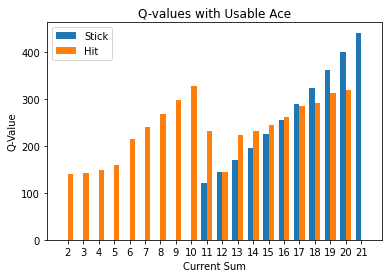

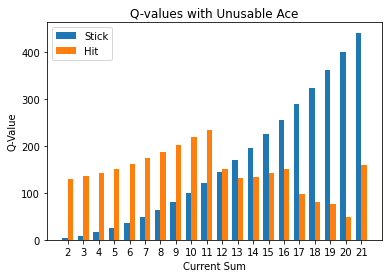

In [79]:
plot_monte_carlo_q_values(agent_v1, usable_ace=True, deck_feature_representative=1)  # For usable ace
plot_monte_carlo_q_values(agent_v1, usable_ace=False, deck_feature_representative=1) # For unusable ace

In [34]:
def evaluate_agent(n_eval_episodes, Q, num_decks=None):
  # Assuming you have an instance of your environment
    env = BlackJackStylised(num_decks=num_decks)
    episode_rewards = []
#   print(Q)
    for episode in tqdm(range(n_eval_episodes)):
        total_rewards_ep = 0
        cards, current_sum, usable_ace, hand_complete = env.reset_init(hard=True)
        # print(env.card_counter)
        # deck_feature = get_deck_feature(env.card_counter)
        # print(deck_feature)
        state = (int(current_sum-2), int(usable_ace))
        done = hand_complete
        
        if num_decks is not None:
      
            while not env.deck_complete: ## 1 episode
                while not done: ## 1 Hand
                    if  env.deck_complete:
                        break
                    # print(Q)
                    # print(int(current_sum), usable_ace)
                    # print(Q[int(current_sum), usable_ace])
                    action = np.argmax(Q[int(current_sum-2), int(usable_ace)])
                    # print(action)
                    next_cards, next_sum, next_usable_ace, hand_complete = env.step(action)
                    # print(next_cards)
                    # next_deck_feature = get_deck_feature(env.card_counter)
                    next_state = (next_sum-2, int(next_usable_ace))
                    reward = 0 if not hand_complete else quadratic_scorer(next_sum)
                    # if hand_complete:
                    #   # print(next_cards, next_sum, next_usable_ace)
                    #   # print('Reward: ', reward) 
                    # else:
                    #   pass
                    state = next_state
                    current_sum = next_sum - 2
                    usable_ace = next_usable_ace 
                    done = hand_complete

                  # print('Hand Finished')
                cards, current_sum, usable_ace, hand_complete = env.reset_init()
            episode_rewards.append(reward)
        else:
            while not done: ## 1 Hand
                # print(Q)
                # print(int(current_sum), usable_ace)
                # print(Q[int(current_sum), usable_ace])
                action = np.argmax(Q[int(current_sum-2), int(usable_ace)])
                # print(action)
                next_cards, next_sum, next_usable_ace, hand_complete = env.step(action)
                # print(next_cards)
                # next_deck_feature = get_deck_feature(env.card_counter)
                next_state = (next_sum-2, int(next_usable_ace))
                reward = 0 if not hand_complete else quadratic_scorer(next_sum)
                # if hand_complete:
                #   # print(next_cards, next_sum, next_usable_ace)
                #   # print('Reward: ', reward) 
                # else:
                #   pass
                state = next_state
                current_sum = next_sum - 2
                usable_ace = next_usable_ace 
                done = hand_complete

                # print('Hand Finished')
                cards, current_sum, usable_ace, hand_complete = env.reset_init()
            episode_rewards.append(reward)
       
            
    mean_reward = np.mean(episode_rewards)
    std_reward = np.std(episode_rewards)

    return mean_reward, std_reward
  


In [35]:
evaluate_agent(n_eval_episodes=10000, Q=agent_v1.Q)

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 9658.80it/s]


(62.0116, 39.39328198360731)